# Libraries

In [3]:
from pathlib import Path
import os
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score

In [4]:
subfolder_path = Path.cwd()
notebooks_path = subfolder_path.parent
repo_path = notebooks_path.parent
os.chdir(str(subfolder_path))
#print current working directory
print(f'Current folder is: {os.getcwd()}\n')
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent.parent)) if sys.path[0] != str(thispath.parent.parent) else None

#Import paths and patients classes
from notebooks.info import path_label, patient


Current folder is: /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks/training_models



# Functions

In [36]:
#print 3 channel image given its numpy array
def show_image_3channels(image):
    """Print 3 channel image given its numpy array
    """
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

def convertzero2one(df):
    #tranfrom dataframe to numpy array
    df = df.to_numpy()
    df[df == 0] = 3
    df[df == 1] = 0
    df[df == 3] = 1
    #convert back to dataframe
    return pd.DataFrame(df)


def unify_labels(kappa_1, kappa_2, best_label2, save = False):
    #Merge all dataframes
    df = pd.concat([kappa_1, kappa_2, best_label2], axis=1)
    #rename columns
    df.columns = ['kappa_1', 'kappa_2', 'best_label2']
    #Create a new column with the majority vote
    df['majority_vote'] = df.mode(axis=1)[0]
    #save in new column same labels as majority vote but change to 2 if 2 is present in any of the 3 columns
    df['new_label'] = df['majority_vote']
    df.loc[(df['kappa_1'] == 2) | (df['kappa_2'] == 2) | (df['best_label2'] == 2), 'new_label'] = 2
    #Save csv file
    df.to_csv(str(repo_path) + '/data/3_classes_SVC_unified.csv', index=False) if save else None
    #drop all columns except new_label
    df = df.drop(['kappa_1', 'kappa_2', 'best_label2', 'majority_vote'], axis=1)
    
    
    return df

# Checking Kappa

## Three classes

In [22]:
#Read predictions from csv file
RF_predict = pd.read_csv(str(repo_path) + '/data/results/3_classes_RF_121_2713.csv')
XGB_predict = pd.read_csv(str(repo_path) + '/data/results/3_classes_XGB_121_2713.csv')
Stack_predict = pd.read_csv(str(repo_path) + '/data/results/3_classes_Stacking_121_2713.csv')
#RF_predict = convertzero2one(RF_predict)

alex_predict = pd.read_excel(str(repo_path) + '/data/results/Cortina_Yalcin_three_class_results2.xlsx', header=None)

RF_predict.values.shape
alex_predict.values.shape

cohen_kappa_score(XGB_predict.values, alex_predict.values)

0.7198553892884044

In [49]:
final_predict = unify_labels(RF_predict, XGB_predict, Stack_predict, save = True)
#count values in pandas dataframe
count = final_predict['new_label'].value_counts()
print(count)
print(f' Kappa comparison with other teams: {cohen_kappa_score(final_predict.values, alex_predict.values)}')
final_predict.to_excel(str(repo_path) + '/data/results/3_classes_ensamble.xlsx', index=False, header=False)

0.0    1127
1.0     863
2.0     131
Name: new_label, dtype: int64
 Kappa comparison with other teams: 0.714750247962862


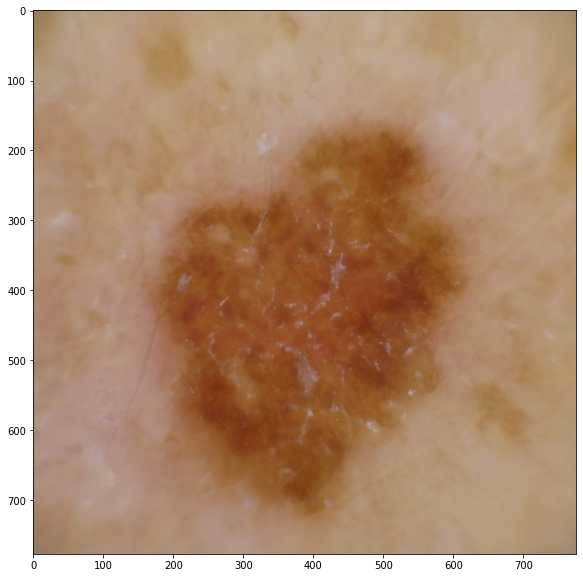

In [47]:
info = path_label(classif='binary', set_name='train')
i = 105
pacient = patient(info, i, NH = True)

show_image_3channels(pacient.RGB_im())